<a href="https://colab.research.google.com/github/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_07_3_style_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generating GANs with Desired Features

In this notebook I show you you can use GANs to create faces that contain features that you desire.  In this case I wanted to create a Kaggle competition for my students to detect if faces had glasses or not.  This turned out to be a fairly easy Kaggle, but I think the process I used to generate faces with glasses or not is interesting.  You can see the Kaggle here.

* [Glasses or Not Kaggle](https://www.kaggle.com/c/applications-of-deep-learningwustl-spring-2020/overview)

I used Google CoLab to run this, a GPU is required.

You can see a YouTube video on this notebook:

* [Controlling if GANs Have Glasses or Not](https://www.kaggle.com/c/applications-of-deep-learningwustl-spring-2020/overview)

In [0]:
# Run this for Google CoLab (use TensorFlow 1.x)
%tensorflow_version 1.x
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

TensorFlow 1.x selected.
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Next, clone StyleGAN2 from GitHub.

In [0]:
!git clone https://github.com/NVlabs/stylegan2.git

Cloning into 'stylegan2'...
remote: Enumerating objects: 93, done.
remote: Total 93 (delta 0), reused 0 (delta 0), pack-reused 93
Unpacking objects: 100% (93/93), done.


Verify that StyleGAN has been cloned.

In [0]:
!ls /content/stylegan2/

dataset_tool.py  LICENSE.txt		 README.md	   run_training.py
dnnlib		 metrics		 run_generator.py  test_nvcc.cu
Dockerfile	 pretrained_networks.py  run_metrics.py    training
docs		 projector.py		 run_projector.py


# Run StyleGAN2 From Python Code

Add the StyleGAN folder to Python so that you can import it.  The code below is based on code from NVidia. This actually generates your images.

In [0]:
import sys
sys.path.insert(0, "/content/stylegan2")

import dnnlib

In [0]:
# Copyright (c) 2019, NVIDIA Corporation. All rights reserved.
#
# This work is made available under the Nvidia Source Code License-NC.
# To view a copy of this license, visit
# https://nvlabs.github.io/stylegan2/license.html

import argparse
import numpy as np
import PIL.Image
import dnnlib
import dnnlib.tflib as tflib
import re
import sys

import pretrained_networks

#----------------------------------------------------------------------------

def expand_seed(seeds, vector_size):
  result = []

  for seed in seeds:
    rnd = np.random.RandomState(seed)
    result.append( rnd.randn(1, vector_size) ) 
  return result

def generate_images(Gs, seeds, truncation_psi, prefix):
    noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]

    Gs_kwargs = dnnlib.EasyDict()
    Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    Gs_kwargs.randomize_noise = False
    if truncation_psi is not None:
        Gs_kwargs.truncation_psi = truncation_psi

    for seed_idx, seed in enumerate(seeds):
        print('Generating image for seed %d/%d ...' % (seed_idx, len(seeds)))
        rnd = np.random.RandomState(0)
        tflib.set_vars({var: rnd.randn(*var.shape.as_list()) for var in noise_vars}) # [height, width]
        images = Gs.run(seed, None, **Gs_kwargs) # [minibatch, height, width, channel]
        path = f"/content/{prefix}-{seed_idx+1}.png"
        PIL.Image.fromarray(images[0], 'RGB').save(path)


In [0]:
sc = dnnlib.SubmitConfig()
sc.num_gpus = 1
sc.submit_target = dnnlib.SubmitTarget.LOCAL
sc.local.do_not_copy_source_files = True
sc.run_dir_root = "/content/drive/My Drive/projects/stylegan2"
sc.run_desc = 'generate-images'
network_pkl = 'gdrive:networks/stylegan2-ffhq-config-f.pkl'

print('Loading networks from "%s"...' % network_pkl)
_G, _D, Gs = pretrained_networks.load_networks(network_pkl)
vector_size = Gs.input_shape[1:][0]

Loading networks from "gdrive:networks/stylegan2-ffhq-config-f.pkl"...
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Compiling... Loading... Done.


# Explore Many GANs

The first thing I did was generate many different GAN's randomly.  I am going to choose from those to find ones with the traits that I am looking for.

In [0]:
import cv2 
from google.colab.patches import cv2_imshow

# 8227
for i in range(100):
  z = 9200+i
  print(z)
  seeds = expand_seed([z], vector_size)
  generate_images(Gs, seeds, 0.5, "image")
  img = cv2.imread('/content/image-1.png')   
  cv2_imshow(img) 

# Modify Single GAN

This section I used mainly to generate the art for the Kaggle.  I wanted to see if I could generate the same person both with and without glasses.  I modified the latent vector until I was able to see the glasses vanish.  Then I minimized the change to the vector until the glasses returned.

Generating image for seed 0/1 ...


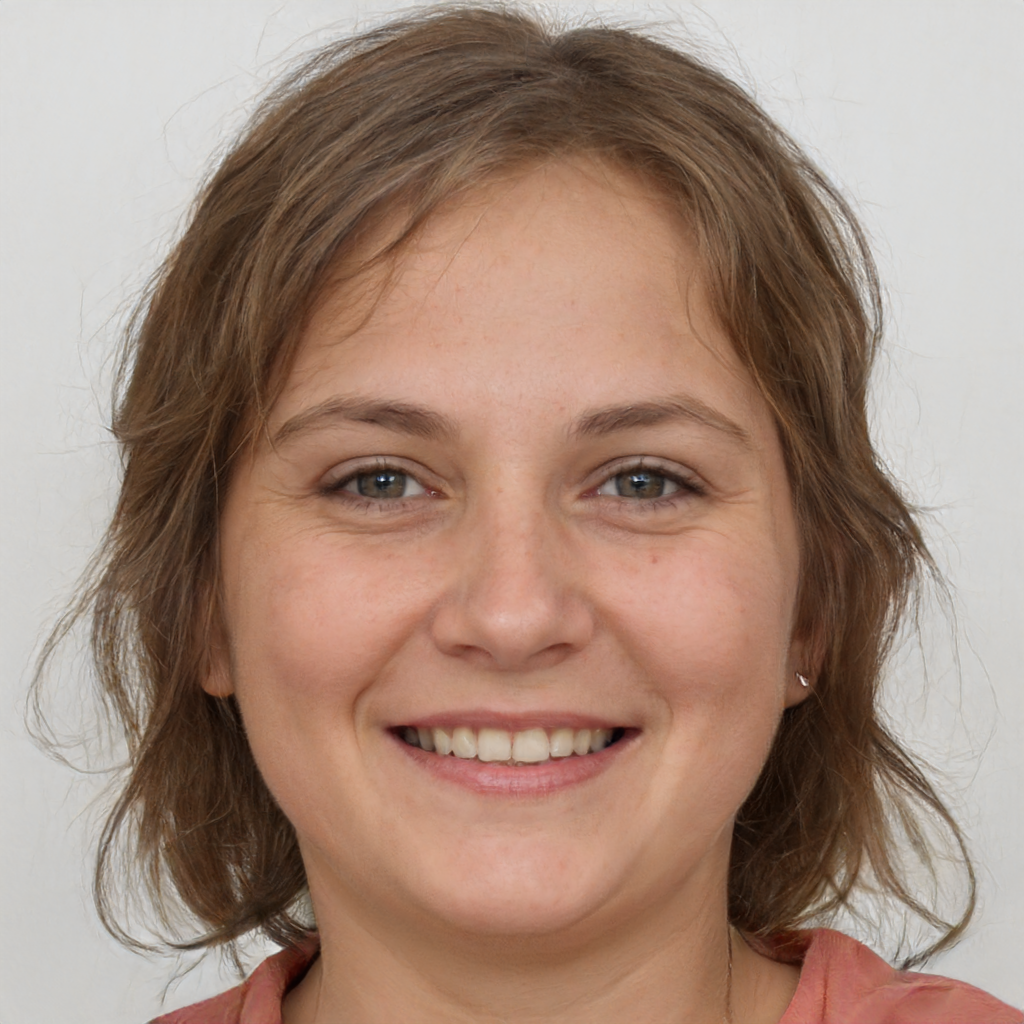

In [0]:
import cv2 
from google.colab.patches import cv2_imshow

seeds = expand_seed([9220], vector_size)

generate_images(Gs, seeds, 0.5, "image")
img = cv2.imread('/content/image-1.png')   
cv2_imshow(img) 

# Explore Elements of Vector

This section of code let me explore 10-block sections of the latent vector looking for what part might affect the attribute I desire.

In [0]:
import cv2 
from google.colab.patches import cv2_imshow

i = 0

while i<500:
  seeds = expand_seed([9223], vector_size)
  seeds[0][0][i:i+10] = -2
  print(i)
  generate_images(Gs, seeds, 0.5, "image")
  img = cv2.imread('/content/image-1.png')   
  cv2_imshow(img) 
  i+=10

0
Generating image for seed 0/1 ...


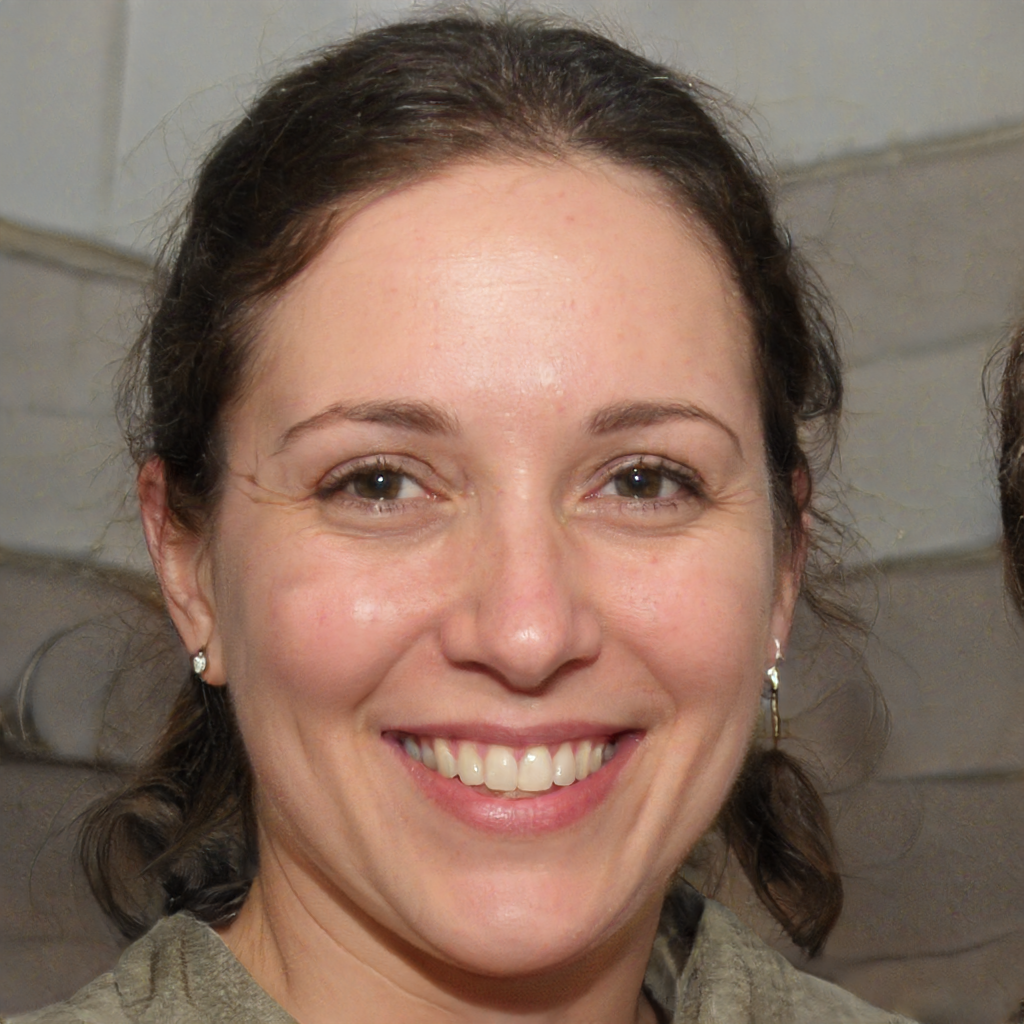

In [0]:
import cv2 
from google.colab.patches import cv2_imshow

i = 0

seeds = expand_seed([9223], vector_size)
#seeds[0][0][410] = -2
#seeds[0][0][411] = -2
seeds[0][0][412] = -2
#seeds[0][0][413] = -2
seeds[0][0][414] = -2
#seeds[0][0][415] = -2
#seeds[0][0][416] = -2
#seeds[0][0][417] = -2
seeds[0][0][418] -= 1.3
#seeds[0][0][419] = -2
print(i)
generate_images(Gs, seeds, 0.5, "image")
img = cv2.imread('/content/image-1.png')   
cv2_imshow(img) 
i+=1

# What is an Image??

In [0]:
sc = dnnlib.SubmitConfig()
sc.num_gpus = 1
sc.submit_target = dnnlib.SubmitTarget.LOCAL
sc.local.do_not_copy_source_files = True
sc.run_dir_root = "/content/drive/My Drive/projects/stylegan2"
sc.run_desc = 'generate-images'
network_pkl = 'gdrive:networks/stylegan2-ffhq-config-f.pkl'

print('Loading networks from "%s"...' % network_pkl)
_G, _D, Gs = pretrained_networks.load_networks(network_pkl)
vector_size = Gs.input_shape[1:][0]

Loading networks from "gdrive:networks/stylegan2-ffhq-config-f.pkl"...
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Compiling... Loading... Done.


In [0]:
GLASSES = [2,3,17,19,26,40,42,50,44,65,68,70,85,90,96,112,
  130,139,140,146,147,152,155,164,176,183,194,198,209,214,215,241,244,245,254,260,
  267,296,300,312,313,322,324,331,333,346,361,366,386,401,412,422,425,443,448,472,
  487,494,501,516,544,545,551,552,565,568,591,594,595,597,607,610,639,640,669,670,
  675,682,703,710,719,730,757,764,765,767,777,780,792,798,799,802,808,812,819,823,
  837,857,866,870,881,887,893,894,895,899,915,916,934,936,941,973,979,988,991,993]

NO_GLASSES = [x for x in range(1000) if x not in GLASSES]

In [0]:
import random
import pandas as pd

GEN_SET = GLASSES

def generate_set(GEN_SET, count):
  seeds3 = []

  for i in range(count):
    i1 = random.randint(0,len(GEN_SET)-1)
    i2 = random.randint(0,len(GEN_SET)-1)
    seeds1 = expand_seed([GEN_SET[i1]],vector_size)
    seeds2 = expand_seed([GEN_SET[i2]],vector_size)
    seeds = [seeds1[0][0], seeds2[0][0]]

    diff = seeds[1] - seeds[0]
    delta = (np.random.rand(512) * 0.6) + .2
    step = diff * delta
    current = [seeds[0].copy()]
    current += step
    current = np.round(current,5)
    seeds3.append(current)

  seeds4 = [x[0] for x in seeds3]
  seeds4 = np.array(seeds4)
  return pd.DataFrame(seeds4)



#generate_images(Gs, seeds3,0.5,'glasses')

df1 = generate_set(GLASSES, int(5000 * .64))
df1['glasses'] = 1
df2 = generate_set(NO_GLASSES, int(5000 * .36))
df2['glasses'] = 0

In [0]:
df = pd.concat([df1,df2],ignore_index=True)

In [0]:
v_cols2 = [f'v{i+1}' for i in range(512)]
cols2 = v_cols2.copy()
cols2.append('glasses')
df.columns = cols2
df = df.reindex(np.random.permutation(df.index))
df.insert(0, 'id', range(1,len(df)+1))

In [0]:
l = len(df)
sz = int(l*.9)
df_train = df[0:sz].copy()
df_test = df[sz:].copy()
df_test.drop('glasses',axis=1,inplace=True)
df_solution = df[sz:].copy()
df_sample = df_test.copy()
df_sample['glasses'] = 0.64

In [0]:
df_train.to_csv('/content/train.csv',index=False)
df_test.to_csv('/content/test.csv',index=False)
df_solution.to_csv('/content/solution.csv',index=False)
df_sample.to_csv('/content/sample.csv',index=False)


# Build Images

In [0]:
df.shape

(5000, 514)

In [0]:
seeds = df[v_cols2].values
seeds = [x.reshape([1,512]) for x in seeds]
generate_images(Gs, seeds,0.5,"face")

Streaming output truncated to the last 5000 lines.
Generating image for seed 1/5000 ...
Generating image for seed 2/5000 ...
Generating image for seed 3/5000 ...
Generating image for seed 4/5000 ...
Generating image for seed 5/5000 ...
Generating image for seed 6/5000 ...
Generating image for seed 7/5000 ...
Generating image for seed 8/5000 ...
Generating image for seed 9/5000 ...
Generating image for seed 10/5000 ...
Generating image for seed 11/5000 ...
Generating image for seed 12/5000 ...
Generating image for seed 13/5000 ...
Generating image for seed 14/5000 ...
Generating image for seed 15/5000 ...
Generating image for seed 16/5000 ...
Generating image for seed 17/5000 ...
Generating image for seed 18/5000 ...
Generating image for seed 19/5000 ...
Generating image for seed 20/5000 ...
Generating image for seed 21/5000 ...
Generating image for seed 22/5000 ...
Generating image for seed 23/5000 ...
Generating image for seed 24/5000 ...
Generating image for seed 25/5000 ...
Generati

In [0]:
!zip /content/drive/My\ Drive/projects/images.zip /content/*

Streaming output truncated to the last 5000 lines.
  adding: content/face-1007.png (deflated 0%)
  adding: content/face-1008.png (deflated 0%)
  adding: content/face-1009.png (deflated 0%)
  adding: content/face-100.png (deflated 0%)
  adding: content/face-1010.png (deflated 0%)
  adding: content/face-1011.png (deflated 0%)
  adding: content/face-1012.png (deflated 0%)
  adding: content/face-1013.png (deflated 0%)
  adding: content/face-1014.png (deflated 0%)
  adding: content/face-1015.png (deflated 0%)
  adding: content/face-1016.png (deflated 0%)
  adding: content/face-1017.png (deflated 0%)
  adding: content/face-1018.png (deflated 0%)
  adding: content/face-1019.png (deflated 0%)
  adding: content/face-101.png (deflated 0%)
  adding: content/face-1020.png (deflated 0%)
  adding: content/face-1021.png (deflated 0%)
  adding: content/face-1022.png (deflated 0%)
  adding: content/face-1023.png (deflated 0%)
  adding: content/face-1024.png (deflated 0%)
  adding: content/face-1025.png

In [0]:
!ls -l /content/drive/My\ Drive/projects/images.zip

-rw------- 1 root root 6560146331 Feb 20 15:14 '/content/drive/My Drive/projects/images.zip'


In [0]:
!ls -l /content/*.csv

-rw-r--r-- 1 root root  2155723 Feb 20 14:06 /content/sample.csv
-rw-r--r-- 1 root root  2154223 Feb 20 14:06 /content/solution.csv
-rw-r--r-- 1 root root  2153215 Feb 20 14:06 /content/test.csv
-rw-r--r-- 1 root root 19366156 Feb 20 14:06 /content/train.csv
